# Lab 5: Spam Detection

**Deadline**: Monday, Mar 14, 5:00 PM

**Late Penalty**: Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Hossein Yousefi <hossein.yousefi@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1BYR00UOS3nEUMWShfs3fHK3jOJR3r7eU?usp=sharing

#Aritejh KR Goil, 1008682971

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

In [ ]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

--2022-03-10 18:49:11--  http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K  1.18MB/s    in 0.2s    

2022-03-10 18:49:11 (1.18 MB/s) - ‘smsspamcollection.zip’ saved [203415/203415]



In [ ]:
!unzip /content/smsspamcollection.zip

Archive:  /content/smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

According to the readme, label value for spam is 'spam' and label for non-spam message is 'ham'.

In [ ]:
import csv
smsfile = open('SMSSpamCollection')
sms = csv.reader(smsfile, delimiter = "\t")
for line in sms: 
  if line[0] == 'spam':
    print (f"spam example: {line[1]}")
    break
for line in sms: 
  if line[0] == 'ham':
    print (f"non-spam example: {line[1]}")
    break

spam example: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
non-spam example: U dun say so early hor... U c already then say...


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam, ham = 0,0

for line in sms:
  if line[0] == 'spam':
    spam += 1
  else:
    ham +=1

print(f"there are {spam} spam messages and {ham} non-spam messages")

there are 746 spam messages and 4822 non-spam messages


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Two advantages of modelling SMS as a sequence of characters is the ability to work with misspelled words and a smaller vocabulary. Two disadvantages would be the additional complexity due to increased numbers of tokens, making it more complex, and the lowered accuracy.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext
import random
text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

print(dataset[0].sms)
print(dataset[0].label)

train_data, val_data, test_data = dataset.split(split_ratio = [0.6, 0.2, 0.2], random_state=random.seed(99))
print(f'There are {len(train_data)} data samples in the train set, {len(val_data)} in val set, and {len(test_data)} in the test set')


Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
0
There are 3343 data samples in the train set, 1115 in val set, and 1114 in the test set


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train_data.examples
# get all the spam messages in `train`
train_spam = []
for item in train_data.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_data.examples = old_train_examples + train_spam * 6

It is important to have a balanced dataset as a dominant class can teach the model to predict that specific class overwhelmingly, resulting in a bias. Considering a baseline of predicting non-spam for everything, we would get an accuracy of 0.866 without class balancing. 

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train_data)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)


defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f020d412090>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, '0': 13, 'h': 14, 'd': 15, '.': 16, 'm': 17, 'c': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, '5': 31, 'v': 32, 'S': 33, 'I': 34, 'C': 35, 'O': 36, 'N': 37, '4': 38, '7': 39, 'A': 40, 'x': 41, '3': 42, '6': 43, 'R': 44, '!': 45, '9': 46, ',': 47, 'P': 48, 'U': 49, 'W': 50, 'M': 51, 'L': 52, 'H': 53, 'D': 54, 'G': 55, 'B': 56, 'F': 57, 'Y': 58, '/': 59, '?': 60, "'": 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'j': 69, 'K': 70, '*': 71, ')': 72, 'J': 73, ';': 74, '+': 75, '(': 76, 'Q': 77, '"': 78, '#': 79, 'q': 80, '@': 81, 'Z': 82, '=': 83, '>': 84, 'ü': 85, '<': 86, '$': 87, 'Ü': 88, '_': 89, '\x92': 90, '%': 91, '‘': 92, '|': 93, '[': 94, ']': 95, '…': 96, '\x93': 97, '

`text_field.vocab.stoi` returns a collections.defaultdict instance with mapping each token string (character) to a numerical identifier. 
`text_field.vocab.itos` returns a list of token strings indexed by their numerical identifiers.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` represents unknown tokens.

`<pad>` is used to pad batches and make them the same length

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
for i, batch in enumerate(train_iter):
  if i == 10:
    break
  else:
    pad = sum([True for j in range(len(batch.sms[0][i])) for i in range(len(batch.sms[1])) if batch.sms[0][i][j] == 1])
    print(f'Batch: {i+1} | Length: {int(batch.sms[1][0])} | Pad: {pad}')
    # max length is at the start of the batch
    # pad is calculated by checking each value in sms[0][i][j],
    # which is essentially checking each element if it is == 1, the numerical identifier of pad

Batch: 1 | Length: 28 | Pad: 18
Batch: 2 | Length: 80 | Pad: 59
Batch: 3 | Length: 35 | Pad: 15
Batch: 4 | Length: 147 | Pad: 30
Batch: 5 | Length: 155 | Pad: 23
Batch: 6 | Length: 160 | Pad: 5
Batch: 7 | Length: 77 | Pad: 59
Batch: 8 | Length: 163 | Pad: 15
Batch: 9 | Length: 34 | Pad: 22
Batch: 10 | Length: 89 | Pad: 64


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
input_size = len(text_field.vocab.itos)
print (input_size)

114


In [ ]:
'''
I tried using LSTM, but couldnt get them to work. I have decided to leave them here so i can get feedback on how LSTM implementations can work.

'''




class SpamRNN(nn.Module):
    def __init__(self, dropout):
        self.name = "SpamRNN"
        super(SpamRNN, self).__init__()
        self.embedding = nn.Embedding(114, 114)
        self.rnn = nn.LSTM(114,
                           64,
                           num_layers= 2,
                           bidirectional=True)
                          #  batch_first=True)
        self.fc1 = nn.Linear(64,32)

        # model.add(LSTM(128,input_shape=(embedded_docs.shape),activation='relu',return_sequences=True))
        # self.embed = torch.eye(input_size)
        # self.rnn1 = nn.Sequential(nn.LSTM(input_size, 256, activation='relu'), #nonlinearity = 'relu'),
        #                           nn.BatchNorm2d(256)) #batch_first=True),
        # self.rnn2 = nn.Sequential(nn.LSTM(256, 64, dropout = dropout),#nonlinearity = 'relu'), 
        #                           nn.BatchNorm2d(64))
        # self.rnn3 = nn.Sequential(nn.LSTM(64, 16, dropout = dropout), #nonlinearity = 'relu'),
        #                           nn.BatchNorm2d(16))                         

        self.fc2 = nn.Linear(32, 1) # as this is a binary classifier, 1 output is sufficient
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_length):
        # Look up the embedding
        embedded = self.embedding(text)      
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_length)        # Forward propagate the RNN
        packed_output, (hidden, cell) = self.rnn(packed)
        # hidden = hidden.view(-1, 64) #reshaping the data for Dense layer next
        # out = nn.ReLU(hidden)

        combined = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = combined.squeeze(0).view(-1)
        out = nn.ReLU(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)



        # output, (hidden, _) = self.rnn1(x)
        # output, (hidden, _) = self.rnn2(x)
        # output, (hidden, _) = self.rnn3(x)
        # output, (hidden, _) = self.dropout(x)        
        # out = torch.max(x, dim=1)[0]
        # # Pass the output of the last step to the classifier
        # out = self.fc(out)
        # text_fea = torch.squeeze(text_fea, 1)
        # text_out = torch.sigmoid(text_fea)
        # return out

In [ ]:
class RNN(nn.Module):
    def __init__(self, hidden_size, dropout):
        self.name = "RNN"
        super(RNN, self).__init__()
        self.emb = torch.eye(input_size).to(device)
        self.rnn = nn.RNN(114, hidden_size, batch_first=True) 
        self.fc1 = nn.Linear(hidden_size * 2, 32) # *2 is due to concatenation
        self.fc2 = nn.Linear(32,1)
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, hidden = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)        
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out.squeeze()

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, iter):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total= 0, 0
    model.eval()
    with torch.no_grad():
      for idx, (sms, label) in enumerate(iter):
        label = label.to(device)
        logits = model(sms[0].to(device))
        pred = (torch.sigmoid(logits) > 0.5)
        correct += (pred == label).sum().item()
        total += label.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import matplotlib.pyplot as plt
import os

def train_rnn(model, train, valid, num_epochs, batch_size, learning_rate, hidden_layers, dropout, plot = True):
    model = model.to(device)
    torch.manual_seed(4)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose= True, min_lr=1e-6)
    
    model_path = f"model_{model.name}_bs{batch_size}_lr{learning_rate}_epochs{num_epochs}_hidden{hidden_layers}_dropout{dropout}"
    os.makedirs(os.path.join("/content/backup",model_path), exist_ok = True)
    
    epochs, losses, val_losses, train_acc, val_acc = [], [], [], [], []
    train_iter = torchtext.legacy.data.BucketIterator(
                    train,
                    batch_size=batch_size,
                    sort_key=lambda x: len(x.sms), # to minimize padding
                    sort_within_batch=True,        # sort within each batch
                    repeat=False)                  # repeat the iterator for many epochs
    valid_iter = torchtext.legacy.data.BucketIterator(
                    valid,
                    batch_size=batch_size,
                    sort_key=lambda x: len(x.sms), # to minimize padding
                    sort_within_batch=True,        # sort within each batch
                    repeat=False)                  # repeat the iterator for many epochs

    for epoch in range(num_epochs):
        model.train()
        train_loss_per_epoch, train_batches, val_loss_per_epoch, val_batches = 0.0, 0.0, 0.0, 0.0
        for sms, label in train_iter:
            # sms =  sms.to(device)
            sms_device = sms[0].to(device) 
            label = label.to(device)
            optimizer.zero_grad()
            pred = model(sms_device)# sms[1])
            loss = criterion(pred, label.float())
            train_loss_per_epoch += loss.item()
            train_batches +=1
            loss.backward()
            optimizer.step()
        
        for sms, label in valid_iter:
            sms_device, label = sms[0].to(device), label.to(device)
            optimizer.zero_grad()
            pred = model(sms_device)
            val_loss = criterion(pred, label.float())
            val_loss_per_epoch += val_loss.item()
            val_batches +=1

        epochs.append(epoch)            
        losses.append(float(train_loss_per_epoch)/train_batches)
        train_acc.append(get_accuracy(model, train_iter))
        val_losses.append(float(val_loss_per_epoch)/val_batches) 
        val_acc.append(get_accuracy(model, valid_iter))
        scheduler.step(val_acc[-1])
        print(f"Epoch {epoch + 1}/{num_epochs}: Training loss {losses[-1]:.3f} , Val loss {val_losses[-1]:.3f} , Training accuracy {train_acc[-1]:.3f} , Val accuracy {val_acc[-1]:.3f}")
        if val_acc[-1]==max(val_acc):
            torch.save(model.state_dict(), os.path.join("/content/backup", model_path, "best.pth"))
            print ("best model saved")
        if epoch % 10 == 0:
            torch.save(model.state_dict(), os.path.join("/content/backup", model_path, f"{epoch}.pth"))
            print ("checkpoint model saved")

    print (f"Best training accuracy is {max(train_acc)}")
    print (f"Best val accuracy is {max(val_acc)}")
    if plot: # plotting
      plt.title("Loss Curve")
      plt.plot(epochs, losses, label="Train")
      plt.plot(epochs, val_losses, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.legend(loc='best')
      plt.show()

      plt.title("Accuracy Curve")
      plt.plot(epochs, train_acc, label="Train")
      plt.plot(epochs, val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.show()       

Epoch 1/30: Training loss 0.494 , Val loss 0.161 , Training accuracy 0.947 , Val accuracy 0.961
best model saved
checkpoint model saved
Epoch 2/30: Training loss 0.149 , Val loss 0.200 , Training accuracy 0.967 , Val accuracy 0.948
Epoch 3/30: Training loss 0.120 , Val loss 0.176 , Training accuracy 0.974 , Val accuracy 0.956
Epoch 4/30: Training loss 0.092 , Val loss 0.273 , Training accuracy 0.967 , Val accuracy 0.934
Epoch 5/30: Training loss 0.084 , Val loss 0.126 , Training accuracy 0.984 , Val accuracy 0.965
best model saved
Epoch 6/30: Training loss 0.066 , Val loss 0.147 , Training accuracy 0.990 , Val accuracy 0.967
best model saved
Epoch 7/30: Training loss 0.049 , Val loss 0.162 , Training accuracy 0.992 , Val accuracy 0.961
Epoch     8: reducing learning rate of group 0 to 5.0000e-04.
Epoch 8/30: Training loss 0.048 , Val loss 0.134 , Training accuracy 0.995 , Val accuracy 0.967
best model saved
Epoch 9/30: Training loss 0.029 , Val loss 0.162 , Training accuracy 0.998 , Va

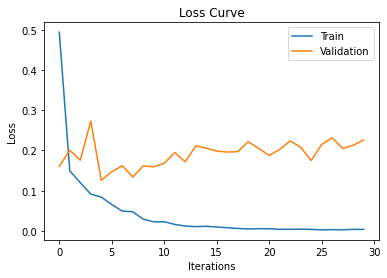

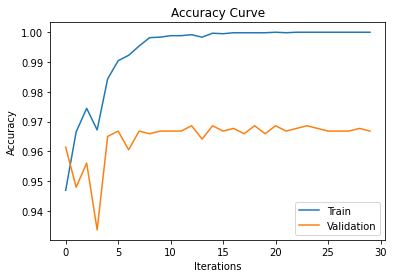

In [ ]:
hidden_layers = 64
dropout = 0.5
batch_size = 32
learning_rate = 0.001 

SimpleRNN = RNN(hidden_layers, dropout)

train_rnn(SimpleRNN, train_data, val_data, num_epochs= 30, batch_size= batch_size, learning_rate=learning_rate, hidden_layers = hidden_layers, dropout = dropout, plot = True)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

The 4 hyperparameters tuned are:

1.   Initial learning rate: 0.001, 0.0005, 0.0001 
2.   Batch size: 32 or 64
3.   Dropout rates: 0.1, 0.25 and 0.5
4.   Hidden layers: 64, 128, 256

Number of epochs is fixed at 20 as model stabilises quickly.


In [ ]:
#first, we experiment with batch size and learning rate with the same model to find the best combination
for batch_size in [32, 64]:
  for learning_rate in [0.001,0.0005,0.0001]:
    print ("--------------------------------------------------------")
    print (f"Training bs{batch_size} lr{learning_rate} ")
    SimpleRNN = RNN(128,0.5)
    train_rnn(SimpleRNN, train_data, val_data, num_epochs= 20, batch_size= batch_size, learning_rate=learning_rate, hidden_layers = 128, dropout = 0.5, plot = False)

--------------------------------------------------------
Training bs32 lr0.001 
Epoch 1/20: Training loss 0.446 , Val loss 0.133 , Training accuracy 0.946 , Val accuracy 0.961
best model saved
checkpoint model saved
Epoch 2/20: Training loss 0.135 , Val loss 0.176 , Training accuracy 0.970 , Val accuracy 0.952
Epoch 3/20: Training loss 0.107 , Val loss 0.128 , Training accuracy 0.977 , Val accuracy 0.965
best model saved
Epoch 4/20: Training loss 0.086 , Val loss 0.173 , Training accuracy 0.979 , Val accuracy 0.951
Epoch 5/20: Training loss 0.066 , Val loss 0.120 , Training accuracy 0.989 , Val accuracy 0.961
Epoch 6/20: Training loss 0.052 , Val loss 0.120 , Training accuracy 0.993 , Val accuracy 0.969
best model saved
Epoch 7/20: Training loss 0.043 , Val loss 0.103 , Training accuracy 0.989 , Val accuracy 0.974
best model saved
Epoch     8: reducing learning rate of group 0 to 5.0000e-04.
Epoch 8/20: Training loss 0.036 , Val loss 0.109 , Training accuracy 0.994 , Val accuracy 0.976

In [ ]:
# best val accuracy at 32 bs and 0.001 lr
for hidden_layers in [64,128,256]:
  for dropout in [0.1,0.25,0.5]:
    print ("--------------------------------------------------------")
    print (f"Training hidden {hidden_layers} dropout {dropout} ")
    SimpleRNN = RNN(hidden_layers,dropout)
    train_rnn(SimpleRNN, train_data, val_data, num_epochs= 20, batch_size = 32, learning_rate=0.001, hidden_layers = hidden_layers, dropout = dropout, plot = False)


--------------------------------------------------------
Training hidden 64 dropout 0.1 
Epoch 1/20: Training loss 0.454 , Val loss 0.122 , Training accuracy 0.952 , Val accuracy 0.964
best model saved
checkpoint model saved
Epoch 2/20: Training loss 0.129 , Val loss 0.145 , Training accuracy 0.969 , Val accuracy 0.961
Epoch 3/20: Training loss 0.106 , Val loss 0.154 , Training accuracy 0.972 , Val accuracy 0.958
Epoch 4/20: Training loss 0.085 , Val loss 0.236 , Training accuracy 0.970 , Val accuracy 0.935
Epoch 5/20: Training loss 0.072 , Val loss 0.120 , Training accuracy 0.985 , Val accuracy 0.966
best model saved
Epoch 6/20: Training loss 0.051 , Val loss 0.114 , Training accuracy 0.991 , Val accuracy 0.968
best model saved
Epoch 7/20: Training loss 0.043 , Val loss 0.105 , Training accuracy 0.945 , Val accuracy 0.968
best model saved
Epoch     8: reducing learning rate of group 0 to 5.0000e-04.
Epoch 8/20: Training loss 0.052 , Val loss 0.104 , Training accuracy 0.991 , Val accur

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in val_data.examples if e.label == 1],
    val_data.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in val_data.examples if e.label == 0],
    val_data.fields)

val_spam= torchtext.legacy.data.BucketIterator(
                    valid_spam,
                    batch_size=32,
                    sort_key=lambda x: len(x.sms), 
                    sort_within_batch=True,        
                    repeat=False)                  

val_nospam = torchtext.legacy.data.BucketIterator(
                    valid_nospam,
                    batch_size=32,
                    sort_key=lambda x: len(x.sms), 
                    sort_within_batch=True,        
                    repeat=False)                  
#best model from hyperparameter testing
model = RNN(256,0.5)
model.load_state_dict(torch.load('/content/backup/model_RNN_bs32_lr0.001_epochs20_hidden256_dropout0.5/best.pth'))
model.to(device)
false_positive_rate = 1 - get_accuracy(model, val_nospam)
false_negative_rate = 1 - get_accuracy(model, val_spam)

print(f"False positive rate on val dataset is {false_positive_rate*100:.3f}%")
print(f"False negative rate on val dataset is {false_negative_rate*100:.3f}%")

False positive rate on val dataset is 0.946%
False negative rate on val dataset is 10.976%


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

False positive would mean the algorithm detects it as spam when it is not, leading to important messahes being missed. This is much worse than a false negative, where the alogrithm would flag a spam message as a normal message, resulting in some spam messages in inbox.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
#since model is loaded...

test = torchtext.legacy.data.BucketIterator(
                    test_data,
                    batch_size=1,
                    sort_key=lambda x: len(x.sms), 
                    sort_within_batch=True,        
                    repeat=False)

test_accuracy = get_accuracy(model, test)
print(f"Test accuracy is {test_accuracy*100:.3f}%")

Test accuracy is 97.846%


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
#since model is loaded...

test_spam = torchtext.legacy.data.Dataset(
    [e for e in test_data.examples if e.label == 1],
    test_data.fields)
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test_data.examples if e.label == 0],
    test_data.fields)

test_spam_loader= torchtext.legacy.data.BucketIterator(
                    test_spam,
                    batch_size=1,
                    sort_key=lambda x: len(x.sms), # to minimize padding
                    sort_within_batch=True,        # sort within each batch
                    repeat=False)                  # repeat the iterator for many epochs

test_nospam_loader = torchtext.legacy.data.BucketIterator(
                    test_nospam,
                    batch_size=1,
                    sort_key=lambda x: len(x.sms), # to minimize padding
                    sort_within_batch=True,        # sort within each batch
                    repeat=False)                  # repeat the iterator for many epochs

test_false_positive_rate = 1 - get_accuracy(model, test_nospam_loader)
test_false_negative_rate = 1 - get_accuracy(model, test_spam_loader)
print(f"False positive rate on test dataset is {test_false_positive_rate*100:.3f}%")
print(f"False negative rate on test dataset is {test_false_negative_rate*100:.3f}%")

False positive rate on test dataset is 1.320%
False negative rate on test dataset is 8.527%


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
#since model is loaded...

msg = "machine learning is sooo cool!"
message = torch.tensor([[text_field.vocab.stoi[letter] for letter in msg]])
pred = model(message)
print(pred)

#prob_of_spam = np.exp(float(pred[0][1])) / (np.exp(float(pred[0][0])) + np.exp(float(pred[0][1])))
#print("probability of the message to be spam is:", prob_of_spam)


tensor(-5.1835, device='cuda:0', grad_fn=<SqueezeBackward0>)


As the prediction is negative, we know that the model predicts this as not a spam message.

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Detecting spam is a difficult task. Increasingly, spam messages try to emulate real-life messages, making it ever harder for the people to distinguish between the two. 
To create a baseline model, a simple classifier which uses the different words used in ham and spam sets, and creating a probability of each word being in a spam versus a non-spam message. After this, we can mulitply the probabilities of the words to obtain a final probability which determine if they are spam or not.